In [20]:
"""
تحليل التوقيت الأمثل لشراء العقارات في دبي
الهدف: تحديد أفضل الشهور والفترات للشراء بناءً على الأنماط الموسمية
"""



'\nتحليل التوقيت الأمثل لشراء العقارات في دبي\nالهدف: تحديد أفضل الشهور والفترات للشراء بناءً على الأنماط الموسمية\n'

In [21]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [22]:

# تحميل البيانات
print("Loading data...")
df = pd.read_csv("C:/Users/tf/Desktop/مشروع 1/Data after cleaning/real_estate_tourism_merged.csv")


Loading data...


In [23]:

# تنظيف وتجهيز البيانات الزمنية
df_clean = df.dropna(subset=[
    'year_month',
    'avg_meter_price',
    'tourism_activity',
    'transactions_count'
])

df_clean['year_month'] = pd.to_datetime(df_clean['year_month'])
df_clean['year'] = df_clean['year_month'].dt.year
df_clean['month'] = df_clean['year_month'].dt.month
df_clean['quarter'] = df_clean['year_month'].dt.quarter

print(f"Records: {len(df_clean)} | Years: {df_clean['year'].min()}–{df_clean['year'].max()}")


Records: 22716 | Years: 2015–2023


In [24]:

# التحليل الشهري المجمع
monthly_stats = df_clean.groupby(['year', 'month']).agg({
    'avg_meter_price': 'mean',
    'tourism_activity': 'mean',
    'transactions_count': 'sum',
    'area_name_en': 'nunique'
}).reset_index()


In [25]:

# أسماء الشهور
month_names = {
    1: 'Jan', 2: 'Feb', 3: 'Mar', 4: 'Apr',
    5: 'May', 6: 'Jun', 7: 'Jul', 8: 'Aug',
    9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'
}

monthly_stats['month_name'] = monthly_stats['month'].map(month_names)


In [26]:

# حساب الأنماط الشهرية عبر السنوات
monthly_patterns = monthly_stats.groupby('month').agg({
    'avg_meter_price': ['mean', 'std', 'min', 'max'],
    'tourism_activity': 'mean',
    'transactions_count': 'mean',
    'area_name_en': 'mean'
}).round(2)

monthly_patterns.columns = ['_'.join(c) for c in monthly_patterns.columns]
monthly_patterns = monthly_patterns.reset_index()
monthly_patterns['month_name'] = monthly_patterns['month'].map(month_names)

print("Monthly patterns ready")


Monthly patterns ready


In [27]:

# حساب نقاط الشراء
def calculate_month_score(row):
    score = 0

    price_percentile = (
        row['avg_meter_price_mean'] - monthly_patterns['avg_meter_price_mean'].min()
    ) / (
        monthly_patterns['avg_meter_price_mean'].max() -
        monthly_patterns['avg_meter_price_mean'].min()
    )
    score += price_percentile * 40

    volatility = (
        row['avg_meter_price_std'] / row['avg_meter_price_mean']
        if row['avg_meter_price_mean'] > 0 else 1
    )
    score += min(volatility * 100, 30)

    transactions_percentile = (
        row['transactions_count_mean'] - monthly_patterns['transactions_count_mean'].min()
    ) / (
        monthly_patterns['transactions_count_mean'].max() -
        monthly_patterns['transactions_count_mean'].min()
    )
    score += transactions_percentile * 20

    tourism_percentile = (
        row['tourism_activity_mean'] - monthly_patterns['tourism_activity_mean'].min()
    ) / (
        monthly_patterns['tourism_activity_mean'].max() -
        monthly_patterns['tourism_activity_mean'].min()
    )
    score += tourism_percentile * 10

    return round(score, 2)

monthly_patterns['buy_score'] = monthly_patterns.apply(calculate_month_score, axis=1)
monthly_patterns = monthly_patterns.sort_values('buy_score')

print("Month ranking calculated")


Month ranking calculated


Seasonal comparison done | Better buying season: Summer
Property timing calculated for 4 types
Charts saved
Monthly results saved
Analysis completed


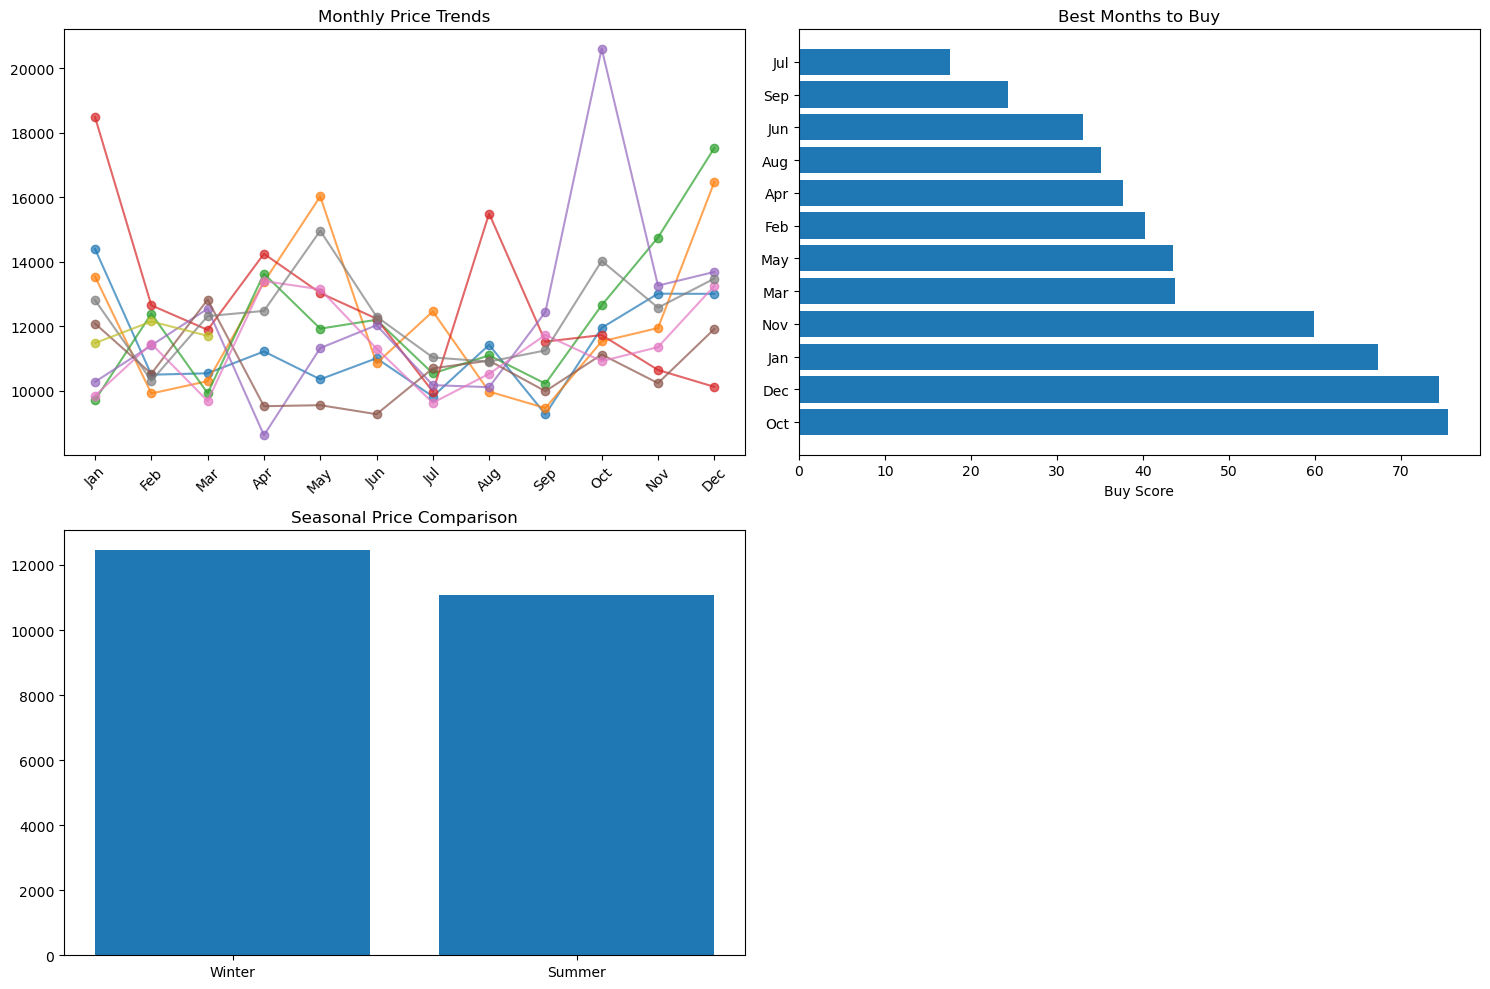

In [28]:

# مقارنة الشتاء والصيف
winter = df_clean[df_clean['month'].isin([12, 1, 2])]
summer = df_clean[df_clean['month'].isin([6, 7, 8])]

if not winter.empty and not summer.empty:
    winter_price = winter['avg_meter_price'].mean()
    summer_price = summer['avg_meter_price'].mean()

    better_season = "Summer" if summer_price < winter_price else "Winter"
    print(f"Seasonal comparison done | Better buying season: {better_season}")

# تحديد التوقيت حسب نوع العقار
property_timing = {}

for prop in df_clean['property_type_en'].dropna().unique():
    prop_data = df_clean[df_clean['property_type_en'] == prop]

    if len(prop_data) < 100:
        continue

    prop_monthly = prop_data.groupby('month').agg({
        'avg_meter_price': 'mean',
        'transactions_count': 'sum'
    }).reset_index()

    cheapest = prop_monthly.loc[prop_monthly['avg_meter_price'].idxmin()]
    busiest = prop_monthly.loc[prop_monthly['transactions_count'].idxmax()]

    property_timing[prop] = {
        'best_price_month': month_names[cheapest['month']],
        'best_price': cheapest['avg_meter_price'],
        'highest_activity_month': month_names[busiest['month']],
        'activity': busiest['transactions_count'],
        'saving_pct': (
            (prop_monthly['avg_meter_price'].max() - cheapest['avg_meter_price']) /
            cheapest['avg_meter_price']
        ) * 100
    }

print(f"Property timing calculated for {len(property_timing)} types")

#  المخططات البيانية 
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

monthly_pivot = monthly_stats.pivot(index='month', columns='year', values='avg_meter_price')
monthly_pivot.index = monthly_pivot.index.map(month_names)

axes[0,0].plot(monthly_pivot.index, monthly_pivot, marker='o', alpha=0.7)
axes[0,0].set_title('Monthly Price Trends')
axes[0,0].tick_params(axis='x', rotation=45)

sorted_months = monthly_patterns.sort_values('buy_score')
axes[0,1].barh(sorted_months['month_name'], sorted_months['buy_score'])
axes[0,1].invert_yaxis()
axes[0,1].set_title('Best Months to Buy')
axes[0,1].set_xlabel('Buy Score')

axes[1,0].bar(['Winter', 'Summer'], [winter_price, summer_price])
axes[1,0].set_title('Seasonal Price Comparison')

axes[1,1].axis('off')

plt.tight_layout()

# حفظ النتائج النهائية
monthly_patterns.to_csv("monthly_buying_analysis.csv", index=False)
print("Monthly results saved")

with open("buying_timing_recommendations.txt", "w") as f:
    f.write("Best Timing to Buy Real Estate in Dubai\n")
    f.write("=" * 40 + "\n")
    for i, (_, r) in enumerate(monthly_patterns.head(3).iterrows(), 1):
        f.write(f"{i}. {r['month_name']} | Avg price: {r['avg_meter_price_mean']:,.0f}\n")

print("Analysis completed")
